Find Players with low potentials but high actual Rating
- Until 21 Rating under 80 and Potential under 80
- between 22 and 32 Rating over 85

In [1]:
import os
import pandas as pd
import numpy as np
import sys
import os
def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")
find_and_append_module_path()
os.getcwd()

import requests
from bs4 import BeautifulSoup
from src.sport_analytics.crawler.fifa import extract_attributes
from tqdm import tqdm

New current directory: c:\Users\Robert\Documents\Projekte\dev\statsfaction


### Get Data

In [2]:
FIFA = "2022"
sql_query = f"""WITH prime AS (
    SELECT Name, ID, MAX(Overall) AS prime
    FROM fifa
    WHERE fifa > YEAR_PLACEHOLDER
    GROUP BY Name
    HAVING MAX(Overall) > 83  -- Filter prime values greater than 85
),
low_potentials AS (
    SELECT Overall, Potential, Name, ID,age
    FROM fifa
    WHERE Age < 25 AND Potential < 81 AND Overall < 80 AND FIFA = YEAR_PLACEHOLDER
)
SELECT prime.Name AS PrimeName,age, low_potentials.Name AS LowPotentialName, prime.ID, prime.prime, low_potentials.Overall AS starting_potential
FROM prime
INNER JOIN low_potentials ON prime.ID = low_potentials.ID"""

In [3]:
sql_diamants = f"""WITH prime AS (
    SELECT Name, ID, MAX(Overall) AS prime
    FROM fifa
    WHERE fifa > YEAR_PLACEHOLDER
    GROUP BY Name
    HAVING MAX(Overall) > 83  -- Filter prime values greater than 85
),
low_potentials AS (
    SELECT Overall, Potential, Name, ID,age
    FROM fifa
    WHERE Age < 25 AND Potential < 81 AND Overall < 80 AND FIFA = YEAR_PLACEHOLDER
)
SELECT prime.Name AS PrimeName,age, low_potentials.Name AS LowPotentialName, prime.ID, prime.prime, low_potentials.Overall AS starting_potential
FROM prime
INNER JOIN low_potentials ON prime.ID = low_potentials.ID"""

sql_dishwasher = """
    SELECT *
    FROM fifa
    WHERE Age < 25 AND Potential < 81 AND Overall < 80 AND FIFA = YEAR_PLACEHOLDER
"""

sql_potentials = """
    SELECT *
    FROM fifa
    WHERE Age < 25 AND Potential < 81 AND Overall < 80 AND FIFA = 2024
"""

In [4]:
import pandas as pd
import sqlite3
DATABASE_PATH = "data/sport_analytics/database/football.db"
# Step 1: Establish a database connection
conn = sqlite3.connect(DATABASE_PATH)


# Step 2: Write your SQL query
data_diamants = pd.DataFrame()
data_dishwasher = pd.DataFrame()

for FIFA in range(2011,2024):
    # Step 3: Use Pandas to execute the query and retrieve the data into a DataFrame
    df_diamants = pd.read_sql_query(sql_diamants.replace("YEAR_PLACEHOLDER",str(FIFA)), conn)
    df_dishwasher = pd.read_sql_query(sql_dishwasher.replace("YEAR_PLACEHOLDER",str(FIFA)), conn)

    df_diamants["FIFA"] = FIFA
    df_dishwasher["FIFA"] = FIFA


    data_diamants = pd.concat([df_diamants,data_diamants])
    data_dishwasher = pd.concat([df_dishwasher,data_dishwasher])

df_potentials_original = pd.read_sql_query(sql_potentials, conn)
# Step 4: Perform data manipulation or analysis using Pandas
# For example, you can display the first few rows of the DataFrame:
# Step 5: Close the database connection when you're done
conn.close()
data_diamants = data_diamants.reset_index()
data_dishwasher  = data_dishwasher.reset_index()

In [5]:
df_potentials = df_potentials_original.copy()

In [6]:
df = pd.merge(data_dishwasher, data_diamants, on=['ID', 'FIFA'], how='left')
df = df.set_index(['ID','Name','FIFA'],drop=True)
df_potentials = df_potentials.set_index(['ID','Name','FIFA'],drop=True)

In [7]:
df = df[[any(pos in i for pos in ['CF', 'LW', 'ST', 'RW']) for i in df['Position']]]
df = df[['LWB' not in i  for i in df.Position]]
df = df[['RWB' not in i  for i in df.Position]]

df_potentials = df_potentials[[any(pos in i for pos in ['CF', 'LW', 'ST', 'RW']) for i in df_potentials['Position']]]
df_potentials = df_potentials[['LWB' not in i  for i in df_potentials.Position]]
df_potentials = df_potentials[['RWB' not in i  for i in df_potentials.Position]]

In [8]:
df["target"] = ~df.PrimeName.isna()
# df["target"] = df['prime']
y = df["target"]

In [9]:
PLAYER_ATTRIBUTES = [ 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
                      'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking','Potential']

In [10]:
PLAYER_ATTRIBUTES = [ 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',  'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 
                      'Potential']

# PLAYER_ATTRIBUTES = [ 'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance',  'Jumping', 'Stamina', 'Strength',  'Aggression', 'Positioning', 'Vision',  'Potential']

###  Feature Engineering

#### Transform Defense Attributs

In [11]:

df['Defense'] =  df['Defensive awareness'].fillna(0)+df['Marking'].fillna(0)
df_potentials['Defense'] =  df_potentials['Defensive awareness'].fillna(0)+df_potentials['Marking'].fillna(0)


# PLAYER_ATTRIBUTES.append('Defense')
df_processed = df[PLAYER_ATTRIBUTES]
df_potentials = df_potentials[PLAYER_ATTRIBUTES]

#### Transform Value

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.sport_analytics.model.eval import plot_correlation_heatmap


# Example usage:
# Assuming you have a DataFrame named 'my_df'
# plot_correlation_heatmap(df_processed)



In [13]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

In [14]:
df['target'].value_counts()

target
False    20883
True        56
Name: count, dtype: int64

In [71]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score
import xgboost as xgb
import lightgbm as lgb
import warnings
from sklearn.model_selection import cross_val_predict, cross_val_score
# Ignore all warnings
import logging

# Suppress LightGBM warning messages
logging.getLogger('lightgbm').setLevel(logging.ERROR)
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')

# Split the data into training and testing sets
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler

# Instantiate the StandardScaler
scaler = StandardScaler()
features = X_train.columns
# Fit the scaler on your training data and transform the data
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train,columns=features)
# Transform the test data using the same scaler
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test,columns=features)


# Define class weights (if applicable)
class_weights = 'balanced'  # You can customize these weights if needed

# Create and train different classification models with class weights
models = {
    'Logistic Regression': LogisticRegression(class_weight=class_weights),
    'Decision Tree Classifier': DecisionTreeClassifier(class_weight=class_weights),
    'Random Forest Classifier': RandomForestClassifier(class_weight=class_weights),
    # 'Support Vector Classifier': SVC(class_weight=class_weights,probability=True,kernel='linear'),
    'XGBoost Classifier': xgb.XGBClassifier(),
    'LightGBM Classifier': lgb.LGBMClassifier(verbose= -1)
}


scoring = ["accuracy","precision","recall","f1_score","roc_auc"]
model_results = {}
cross_val_scores = {}
for model_name, model in models.items():
    print(model_name,"training----->")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = None
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    if y_prob is not None:
        auc = roc_auc_score(y_test, y_prob)
    else:
        auc = None
    
    precision = precision_score(y_test, y_pred)
    
    model_results[model_name] = {
        'Model': model,
        'Accuracy': accuracy,
        'Classification Report': report,
        'Confusion Matrix': conf_matrix,
        'AUC': auc,
        'Precision': precision
    }
    for score in scoring:
        try:
            scores = cross_val_score(model, X_test, y_test, cv=3, scoring=score,verbose=0)
            cross_val_scores[model_name] = scores
            print(f"Val Score {score}",f"{model_name}: {np.round(cross_val_scores[model_name].mean(),4)} +/- {np.round(cross_val_scores[model_name].std(),3)}")
        except:
            print(score)
# Evaluate and print results for each model
for model_name, results in model_results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {results['Accuracy']:.2f}")
    print("Classification Report:")
    print(results['Classification Report'])
    print("Confusion Matrix:")
    print(results['Confusion Matrix'])
    if results['AUC'] is not None:
        print(f"AUC: {results['AUC']:.2f}")
    if 'Precision' in results:
        print(f"Precision: {results['Precision']:.2f}")
    print()


Logistic Regression training----->
Val Score accuracy Logistic Regression: 0.9358 +/- 0.029
Val Score precision Logistic Regression: 0.0046 +/- 0.006
Val Score recall Logistic Regression: 0.2222 +/- 0.314
f1_score
Val Score roc_auc Logistic Regression: 0.6753 +/- 0.083
Decision Tree Classifier training----->
Val Score accuracy Decision Tree Classifier: 0.9964 +/- 0.001
Val Score precision Decision Tree Classifier: 0.0667 +/- 0.094
Val Score recall Decision Tree Classifier: 0.1111 +/- 0.157
f1_score
Val Score roc_auc Decision Tree Classifier: 0.5551 +/- 0.078
Random Forest Classifier training----->
Val Score accuracy Random Forest Classifier: 0.9976 +/- 0.0
Val Score precision Random Forest Classifier: 0.0 +/- 0.0
Val Score recall Random Forest Classifier: 0.0 +/- 0.0
f1_score
Val Score roc_auc Random Forest Classifier: 0.5986 +/- 0.032
XGBoost Classifier training----->
Val Score accuracy XGBoost Classifier: 0.9976 +/- 0.0
Val Score precision XGBoost Classifier: 0.0 +/- 0.0
Val Score re

In [23]:
[m for m in models]

['Logistic Regression',
 'Decision Tree Classifier',
 'Random Forest Classifier',
 'XGBoost Classifier',
 'LightGBM Classifier']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


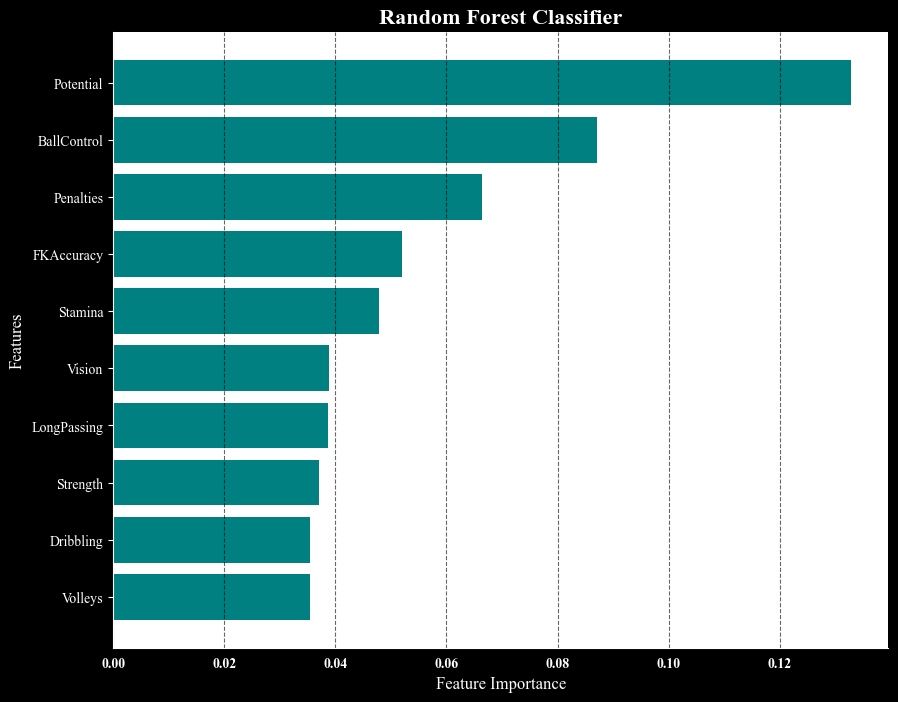

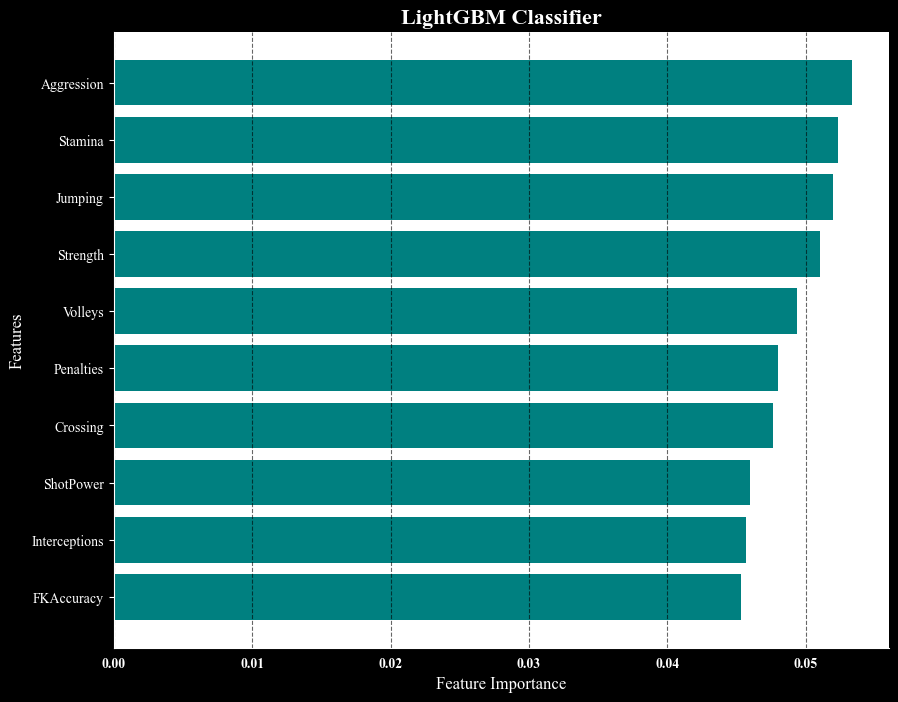

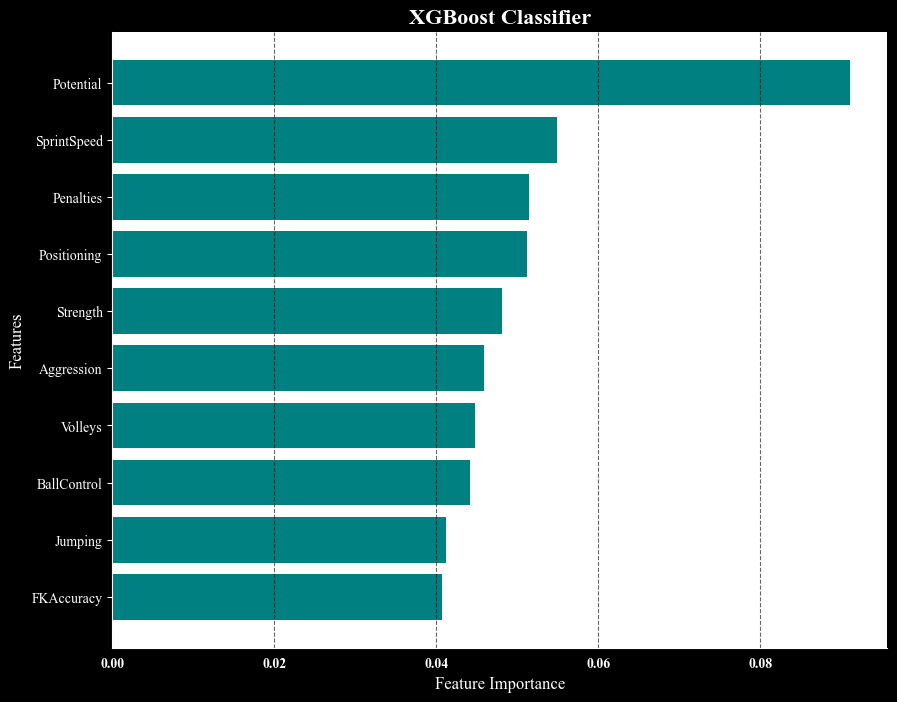

ValueError: Data must be 1-dimensional, got ndarray of shape (1, 25) instead

In [83]:
%load_ext autoreload
%autoreload 2
from src.sport_analytics.model.eval import plot_feature_importance

# Example usage:
my_model = model_results['Random Forest Classifier']['Model']
features = plot_feature_importance(my_model, 'Random Forest Classifier')

my_model = model_results['LightGBM Classifier']['Model']
features = plot_feature_importance(my_model, 'LightGBM Classifier')

my_model = model_results['XGBoost Classifier']['Model']
features = plot_feature_importance(my_model, 'XGBoost Classifier')


### evaluate test data

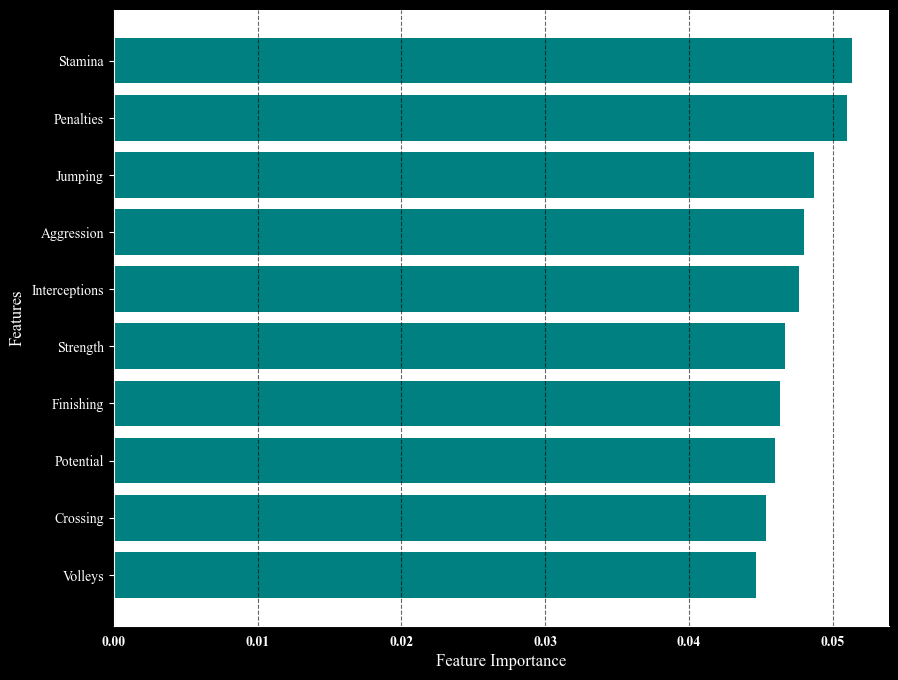

['Stamina',
 'Penalties',
 'Jumping',
 'Aggression',
 'Interceptions',
 'Strength',
 'Finishing',
 'Potential',
 'Crossing',
 'Volleys']

In [26]:
my_model = model_results['LightGBM Classifier']['Model']
features = plot_feature_importance(my_model, '')
features

In [84]:
my_model = model_results[ 'Logistic Regression']['Model']
y_test = pd.DataFrame(my_model.predict_proba(X_test)[:,1],columns=["prediction"],index=y_test.index)
y_test.sort_values(by="prediction",ascending = False).head(20)

,,,prediction
ID,Name,FIFA,
199740,Chula,2012,0.998298
260598,S. Poyraz,2022,0.997749
228923,A. Scherbakov,2017,0.994920
244182,G. Arabidze,2021,0.994291
210398,Y. El Baillal,2013,0.992543
204098,A. Achahbar,2012,0.991730
229517,Toni,2016,0.991252
186144,C. Stewart,2011,0.988851
182694,J. Mattock,2011,0.987939


### predict potentials

In [85]:
my_model = model_results[ 'Logistic Regression']['Model']
prospects = pd.DataFrame(my_model.predict_proba(df_potentials)[:,1],columns=["prediction"],index=df_potentials.index)

df_potentials.to_csv('potentials.csv')
prospects.sort_values(by="prediction",ascending = False).head(30)

,,,prediction
ID,Name,FIFA,
230460,Jonatão Praz,2024,1.0
252750,V. Covil,2024,1.0
263770,O. Alfonsi,2024,1.0
254552,K. Harratt,2024,1.0
254807,K. Baah,2024,1.0
262229,Y. Haouari,2024,1.0
247890,B. Kamwa,2024,1.0
258897,S. Onur,2024,1.0
257617,F. Nyenetue,2024,1.0
